## 控制变量实验，随机划分四个子集进行训练和测试

In [41]:
# tensorflowGPU的设置
import tensorflow as tf

# tf.config.experimental.list_physical_devices('CPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
# 在同时具有CPU和GPU的设备上，优先使用GPU运算, 实际中可以使用with tf.device创建设备上下文
# 例如： with tf.decice('/CPU:0'): 
# 限制内存增长
tf.config.experimental.set_memory_growth(gpus[0], True)

In [42]:
import pandas as pd
import tensorflow as tf
from collections import Counter

data_csv = pd.read_csv('res_handle.csv')

# 随机划分四个子集
data_train = data_csv.sample(frac=1, random_state=1).reset_index(drop=True)
data_1 = data_train[: 6104]
data_2 = data_train[6104: 7953]
data_3 = data_train[7953: 9781]

print("三个数据集各自的规模:",data_1.shape, data_2.shape, data_3.shape)

print("三个数据集按标签进行统计：", Counter(data_１['label']), Counter(data_2['label']), Counter(data_3['label']), Counter(data_csv['label']))

,name,opcode,length,label,first_seen
0,00033a9606f5fe9ed77b994f6b8e42901f5319783d3850...,mov cmp mov push retn,5,trojan,2017-10-18
1,004804cd6b95e1a5aa09d6c893ac51ace90e1c9b16cb2c...,retn mov test jz push mov sub mov call mov sub...,2989,virus,2017-09-20
2,005e0b9944f5f207b45e66493c378a6afc6bffba2030e5...,push mov sub cmp jz cmp mov jnz or mov push ca...,5920,trojan,2017-09-20
3,006c65515ea0c4998bee697c3962a3c4fc225afd5f934f...,nop pusha nop mov nop push nop pop nop cmp nop...,120,trojan,2017-10-20
4,007713edd1589b07bb902b7481dec4bc92bd3dc37b30d8...,push call cmp jz retn mov push call mov pop mo...,77,trojan,2017-10-20


In [45]:
name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}

# 训练数据
codes_train = data_1['name'].to_list()
labels_train = data_1['label'].map(lambda x: name2label[x])
labels_train = labels_train.to_list()
# 第一个测试子集
codes_test_1 = data_2['name'].to_list()
labels_test_1 = data_2['label'].map(lambda x: name2label[x])
labels_test_1 = labels_test_1.to_list()
# 第二个测试子集
codes_test_2 = data_3['name'].to_list()
labels_test_2 = data_3['label'].map(lambda x: name2label[x])
labels_test_2 = labels_test_2.to_list()

In [47]:
# 利用labelencoder构建opcode编码器

from sklearn import preprocessing
from tqdm import tqdm

opcode_all = []
for idx in tqdm(range(data_csv.shape[0])):
    opcode_str = data_csv.at[idx, 'opcode'].split()
    opcode_all += opcode_str
    opcode_all = list(set(opcode_all))

le = preprocessing.LabelEncoder()
le.fit(opcode_all)

print("opcode词库大小：", len(list(le.classes_)))

100%|██████████| 12402/12402 [00:07<00:00, 1570.71it/s]


LabelEncoder()

In [49]:
# 数据预处理函数,选取opcode序列长度的四分位数2850进行padding操作
import numpy as np

def pad_data(res, max_len=2850):
    
    length = len(res)
    if length > max_len:
        return res[ :max_len]
    elif length < max_len:
        return res + [0]*(max_len-length)
    return res


def train_data_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 5100]
        labels = labels[: 5100]
    elif mode == 'val':    
        codes = codes[5100: ]
        labels = labels[5100: ]

    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]

In [51]:
# 创建dataset对象

batch_size = 128
db_train = tf.data.Dataset.from_generator(train_data_generator, args=[codes_train, labels_train, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(45)

db_val = tf.data.Dataset.from_generator(train_data_generator, args=[codes_train, labels_train, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(40)

In [52]:
# 创建TextCNN类
from tensorflow import keras
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=4,
                 last_activation=None):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))

        # Embedding part can try multichannel as same as origin paper
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [2, 3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)
        d_1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
        d = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(d_1)

        output = Dense(self.class_num, activation=self.last_activation)(d)
        model = Model(inputs=input, outputs=output)
        return model

In [53]:
# 实例化TextCNN模型

max_len = 2850
max_features = 641
embedding_dims = 16

model = TextCNN(max_len, max_features, embedding_dims).get_model()

model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])

In [54]:
history = model.fit(db_train,
                    epochs=40,
                    steps_per_epoch=40,
                    validation_data=db_val,
                    validation_steps=8)

Epoch 1/40
40/40 [==============================] - 42s 984ms/step - loss: 3.6505 - categorical_accuracy: 0.3465 - val_loss: 2.2588 - val_categorical_accuracy: 0.5654
Epoch 2/40
40/40 [==============================] - 39s 975ms/step - loss: 2.0155 - categorical_accuracy: 0.6166 - val_loss: 1.3345 - val_categorical_accuracy: 0.7568
Epoch 3/40
40/40 [==============================] - 40s 1s/step - loss: 1.1680 - categorical_accuracy: 0.7965 - val_loss: 0.8536 - val_categorical_accuracy: 0.8906
Epoch 4/40
40/40 [==============================] - 41s 1s/step - loss: 0.8127 - categorical_accuracy: 0.8849 - val_loss: 0.7317 - val_categorical_accuracy: 0.8965
Epoch 5/40
40/40 [==============================] - 41s 1s/step - loss: 0.6612 - categorical_accuracy: 0.9174 - val_loss: 0.5734 - val_categorical_accuracy: 0.9346
Epoch 6/40
40/40 [==============================] - 41s 1s/step - loss: 0.5909 - categorical_accuracy: 0.9290 - val_loss: 0.5513 - val_categorical_accuracy: 0.9385
Epoch 7/40

In [55]:
# 进行模型的保存,保存为textcnn_3

model.save('./model/textcnn_random.h5')

In [56]:
from tqdm import tqdm

def load_test_data(codes, labels):
    
    labels_res = np.eye(4)[labels]
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all), labels_res

In [58]:
from sklearn.metrics import classification_report

codes_train_copy, labels_train_copy = load_test_data(codes_train, labels_train)
y_pred = model.predict(codes_train_copy)
y_true = np.argmax(labels_train_copy, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    backdoor     0.9878    0.9801    0.9839      1655
        worm     0.9836    0.9926    0.9881      1755
       virus     0.9837    0.9792    0.9815      1298
      trojan     0.9878    0.9900    0.9889      1396

    accuracy                         0.9857      6104
   macro avg     0.9858    0.9855    0.9856      6104
weighted avg     0.9858    0.9857    0.9857      6104



In [64]:
# 在第一个测试集上的准确率

codes_test_1, labels_test_1 = load_test_data(codes_test_1, labels_test_1)
y_pred = model.predict(codes_test_1)
y_true = np.argmax(labels_test_1, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    backdoor     0.9406    0.9406    0.9406       471
        worm     0.9470    0.9940    0.9699       503
       virus     0.9874    0.9776    0.9825       402
      trojan     0.9735    0.9302    0.9514       473

    accuracy                         0.9605      1849
   macro avg     0.9621    0.9606    0.9611      1849
weighted avg     0.9609    0.9605    0.9604      1849



In [65]:
# 在第二个测试集上的准确率

codes_test_2, labels_test_2 = load_test_data(codes_test_2, labels_test_2)
y_pred = model.predict(codes_test_2)
y_true = np.argmax(labels_test_2, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    backdoor     0.9419    0.9380    0.9400       484
        worm     0.9449    0.9910    0.9674       554
       virus     0.9860    0.9671    0.9765       365
      trojan     0.9705    0.9294    0.9495       425

    accuracy                         0.9579      1828
   macro avg     0.9608    0.9564    0.9583      1828
weighted avg     0.9583    0.9579    0.9578      1828



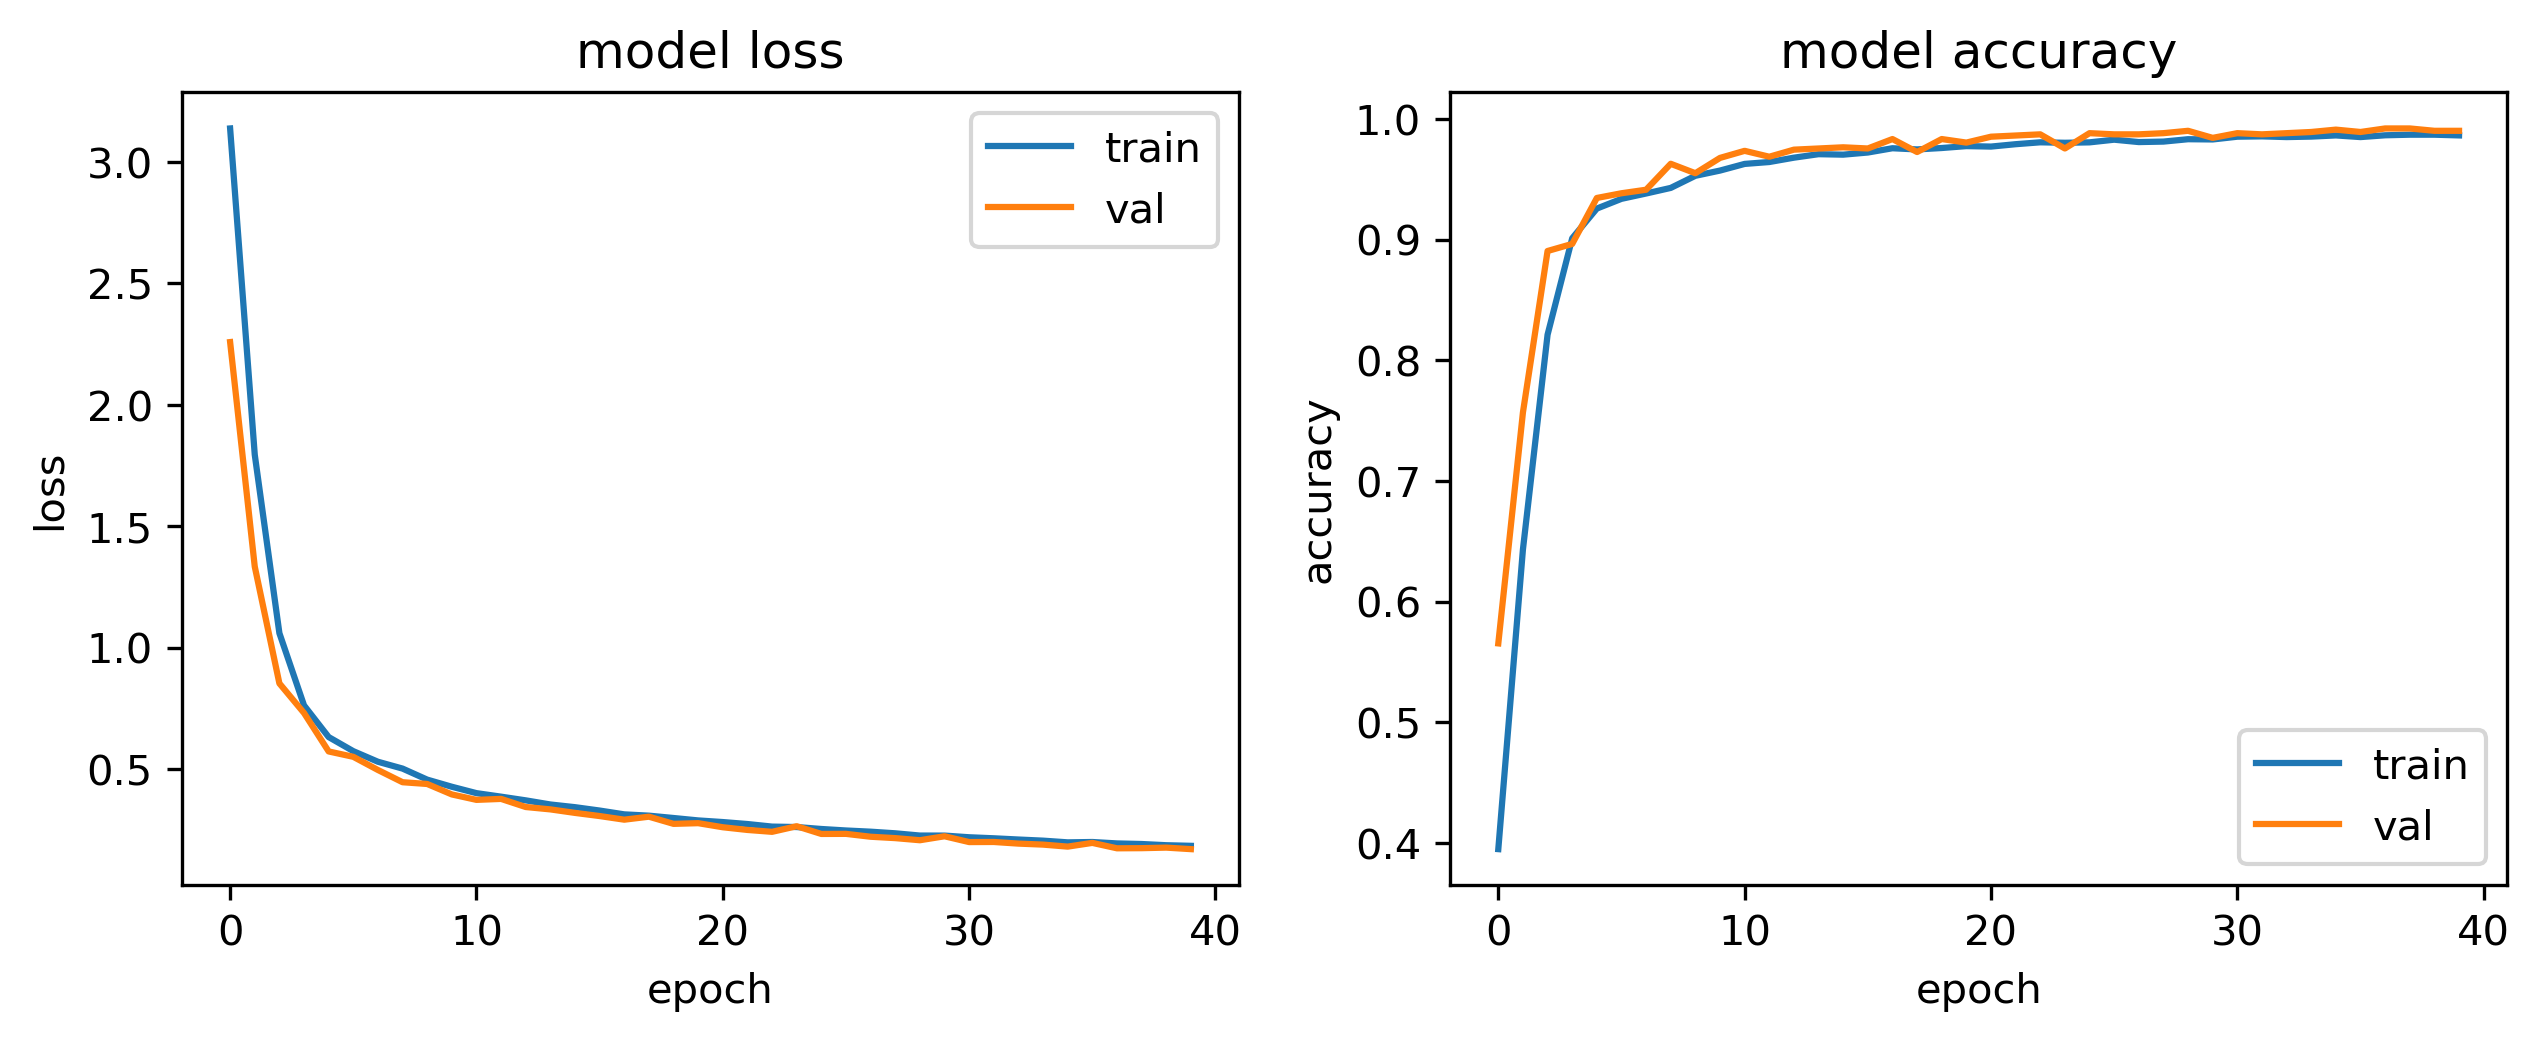

In [62]:
# 绘制loss和acc曲线
import matplotlib.pyplot as plt

def PlotLoss(model_name, history):
    
    p1 = plt.figure(figsize=(10, 3.5),dpi=300)
    ax1 = p1.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="upper right")

    ax2 = p1.add_subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="lower right")
    plt.savefig("./figures/" + model_name + '.png')
    
PlotLoss('textcnn_random', history)